In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.1.0+cu121
device: cuda


In [ ]:
train_data_path = 'fashion-mnist_train.csv'
valid_data_path = 'fashion-mnist_test.csv'
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

img_size = 28
batch_size = 64

z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

epochs = 30
learning_rate = 1e-4

Train data path: fashion-mnist_train.csv
Valid data path: fashion-mnist_test.csv


In [ ]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
dataset = FashionMNIST(train_data_path, img_size)

Image size: (54857, 28, 28)
--- Label ---
5    5509
6    5500
0    5497
8    5487
7    5481
3    5481
4    5479
2    5475
9    5474
1    5474
Name: label, dtype: int64


<ipython-input-29-d73abe5726c9>:5: RuntimeWarning: invalid value encountered in cast
  self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)


In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Image size: (54857, 28, 28)
--- Label ---
5    5509
6    5500
0    5497
8    5487
7    5481
3    5481
4    5479
2    5475
9    5474
1    5474
Name: label, dtype: int64


<ipython-input-29-d73abe5726c9>:5: RuntimeWarning: invalid value encountered in cast
  self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)


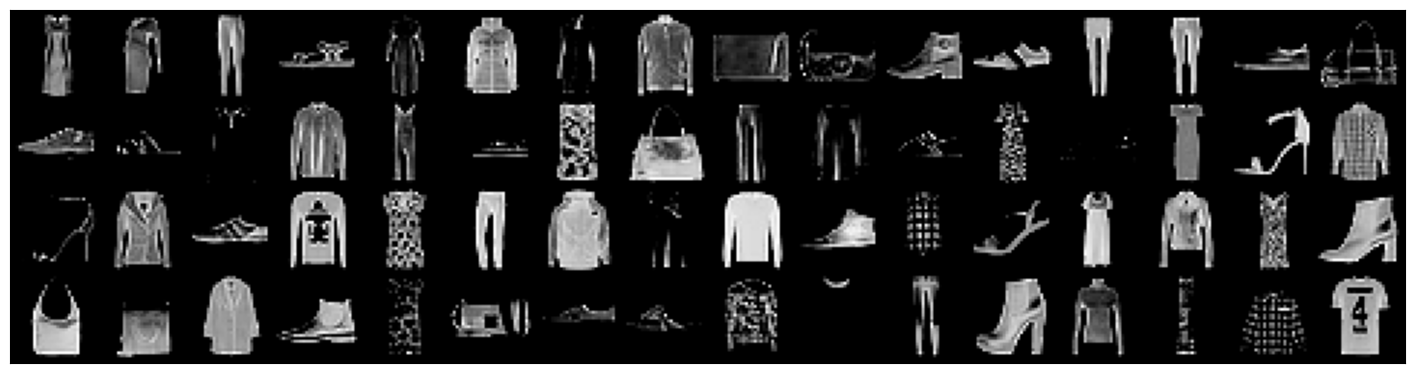

In [ ]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size = img_size

        self.label_emb = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):

        z = z.view(-1, self.z_size)

        c = self.label_emb(labels)

        x = torch.cat([z, c], 1)

        out = self.model(x)

        return out.view(-1, self.img_size, self.img_size)

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):

        x = x.view(-1, self.img_size * self.img_size)

        c = self.label_emb(labels)

        x = torch.cat([x, c], 1)

        out = self.model(x)

        return out.squeeze()

In [ ]:
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)

discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):

    g_optimizer.zero_grad()

    z = Variable(torch.randn(batch_size, z_size)).to(device)

    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    fake_images = generator(z, fake_labels)

    validity = discriminator(fake_images, fake_labels)

    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    g_loss.backward()

    g_optimizer.step()

    return g_loss.data

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):

    d_optimizer.zero_grad()

    real_validity = discriminator(real_images, labels)

    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    z = Variable(torch.randn(batch_size, z_size)).to(device)

    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    fake_images = generator(z, fake_labels)

    fake_validity = discriminator(fake_images, fake_labels)

    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    d_loss = real_loss + fake_loss

    d_loss.backward()

    d_optimizer.step()

    return d_loss.data

Starting epoch 1...
g_loss: 4.214088439941406, d_loss: 0.07327994704246521


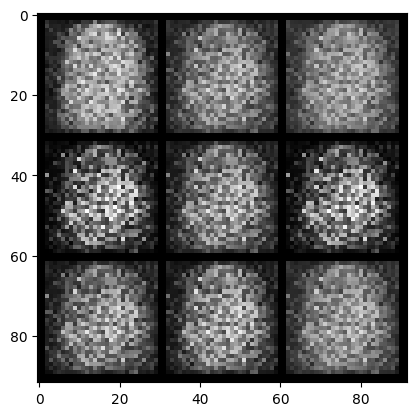

Starting epoch 2...
g_loss: 4.79979133605957, d_loss: 0.5232222676277161


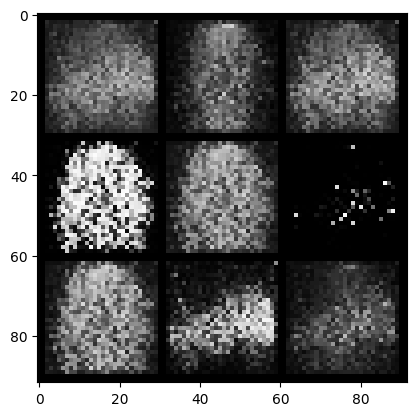

Starting epoch 3...
g_loss: 4.046194076538086, d_loss: 0.2724122405052185


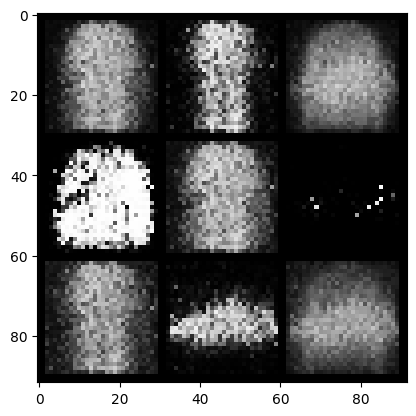

Starting epoch 4...
g_loss: 3.0581414699554443, d_loss: 0.6690121293067932


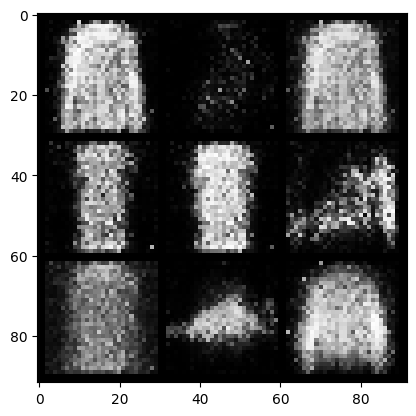

Starting epoch 5...
g_loss: 3.2966952323913574, d_loss: 0.8501036167144775


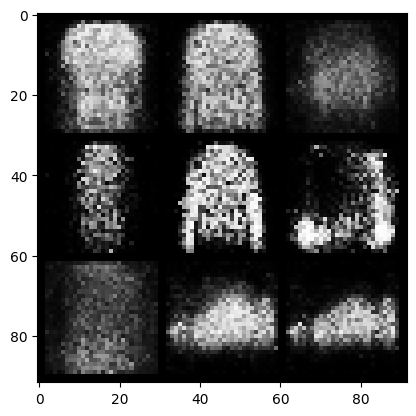

Starting epoch 6...
g_loss: 2.5073013305664062, d_loss: 0.14032147824764252


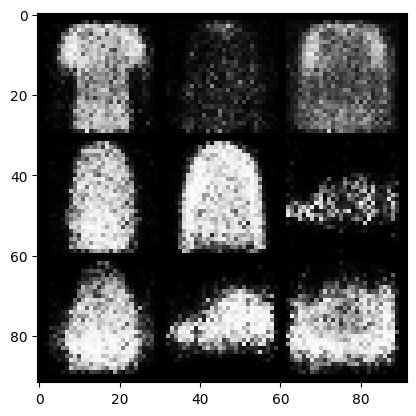

Starting epoch 7...
g_loss: 2.093390464782715, d_loss: 0.616520881652832


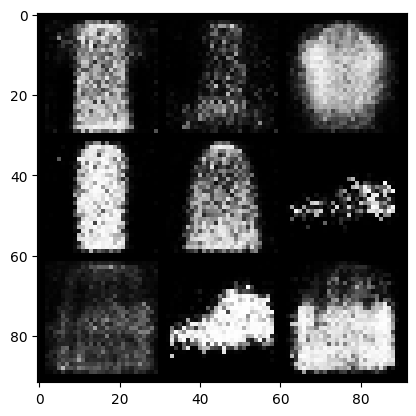

Starting epoch 8...
g_loss: 2.1092827320098877, d_loss: 0.7811322212219238


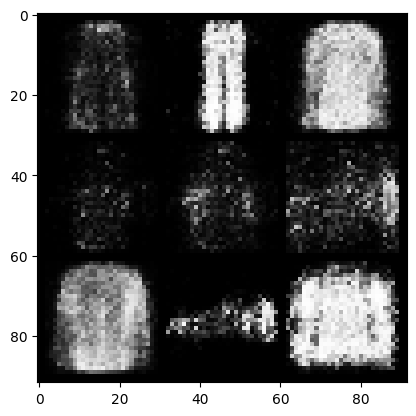

Starting epoch 9...
g_loss: 1.9661606550216675, d_loss: 0.4761162996292114


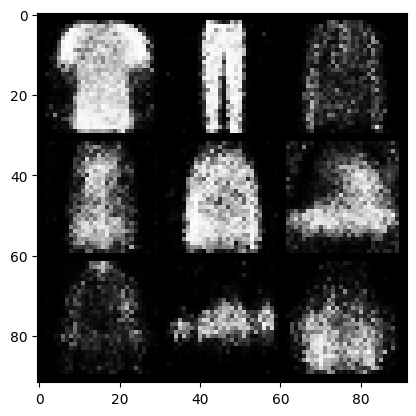

Starting epoch 10...
g_loss: 1.7368433475494385, d_loss: 0.7077469229698181


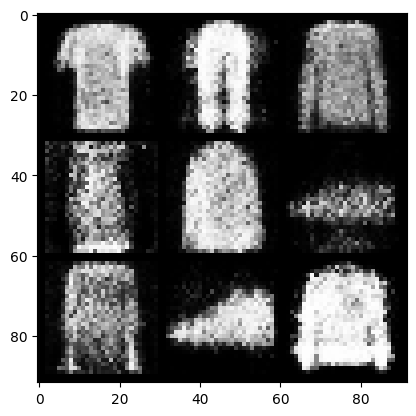

Starting epoch 11...
g_loss: 1.7700729370117188, d_loss: 0.8103394508361816


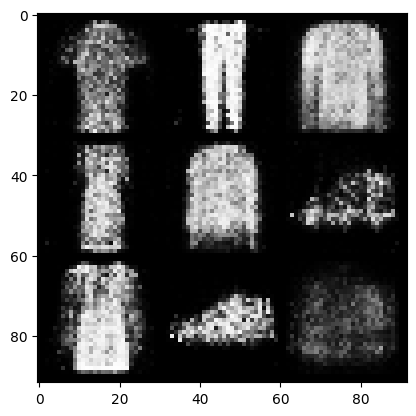

Starting epoch 12...
g_loss: 1.9872630834579468, d_loss: 1.2251219749450684


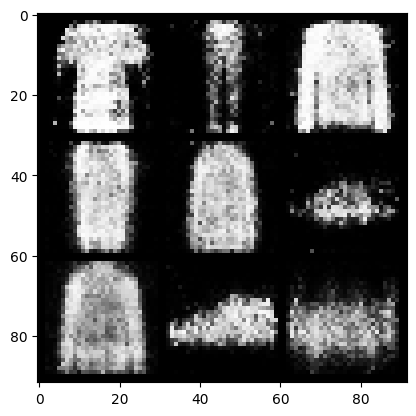

Starting epoch 13...
g_loss: 1.7247905731201172, d_loss: 0.6582655906677246


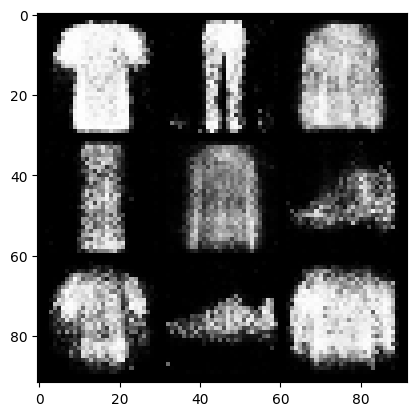

Starting epoch 14...
g_loss: 1.5843260288238525, d_loss: 0.7902719974517822


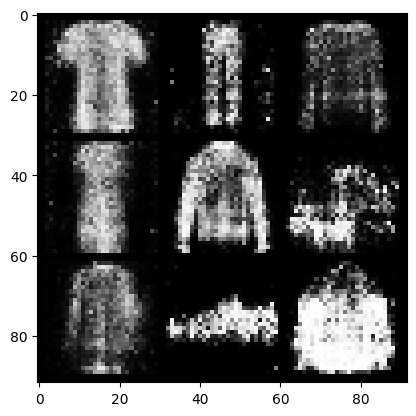

Starting epoch 15...
g_loss: 1.5800964832305908, d_loss: 0.904029369354248


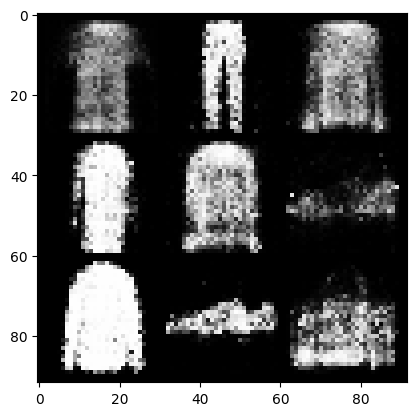

Starting epoch 16...
g_loss: 1.794431209564209, d_loss: 1.0457078218460083


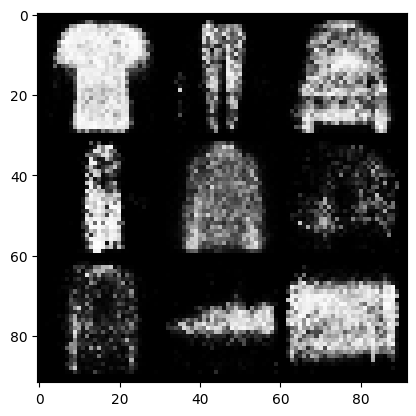

Starting epoch 17...
g_loss: 1.5139235258102417, d_loss: 0.36951225996017456


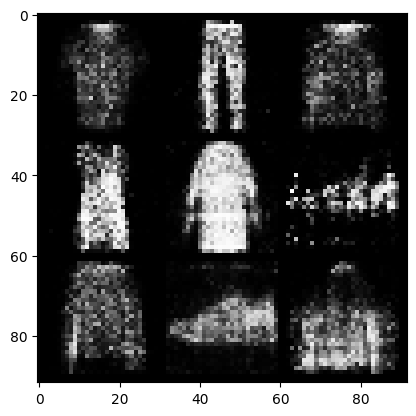

Starting epoch 18...
g_loss: 1.7507511377334595, d_loss: 1.118704915046692


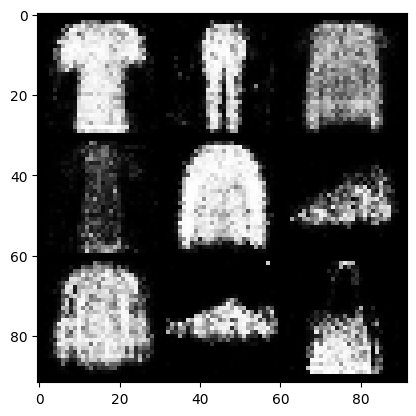

Starting epoch 19...
g_loss: 1.4980735778808594, d_loss: 0.6630492806434631


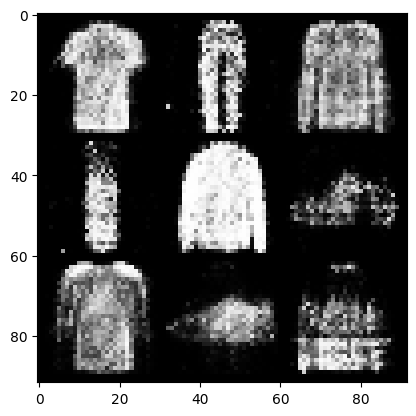

Starting epoch 20...
g_loss: 1.349402904510498, d_loss: 1.8251450061798096


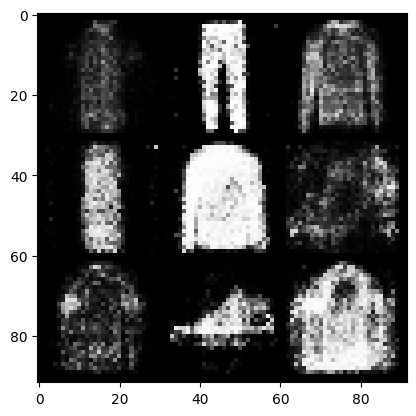

Starting epoch 21...
g_loss: 1.4814159870147705, d_loss: 0.8370993733406067


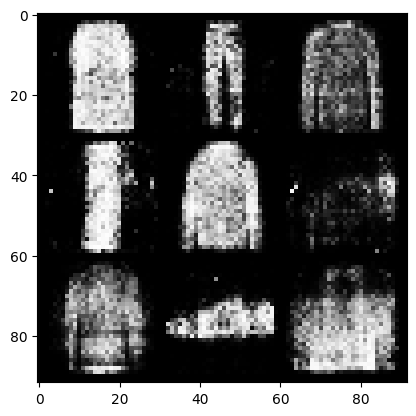

Starting epoch 22...
g_loss: 1.3773398399353027, d_loss: 0.714303731918335


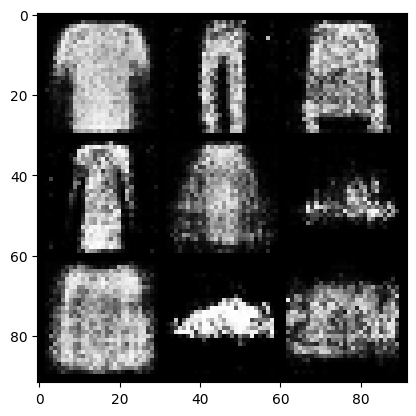

Starting epoch 23...
g_loss: 1.558439016342163, d_loss: 1.4103363752365112


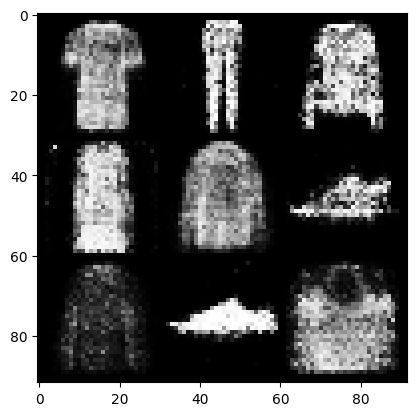

Starting epoch 24...
g_loss: 1.2184844017028809, d_loss: 1.0785242319107056


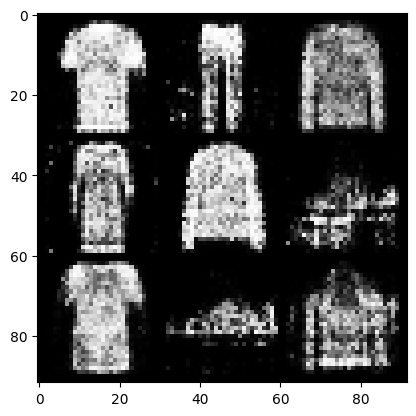

Starting epoch 25...
g_loss: 1.3112118244171143, d_loss: 0.5816022157669067


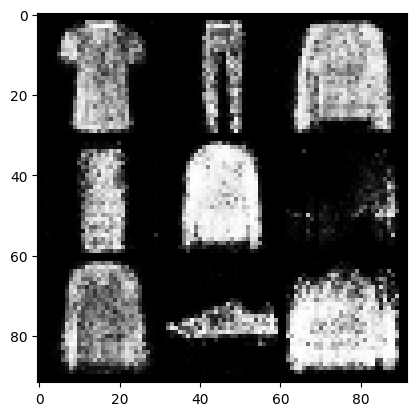

Starting epoch 26...
g_loss: 1.3857911825180054, d_loss: 0.7969949841499329


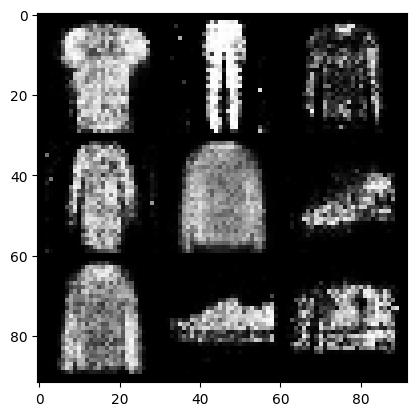

Starting epoch 27...
g_loss: 1.1504745483398438, d_loss: 1.2739052772521973


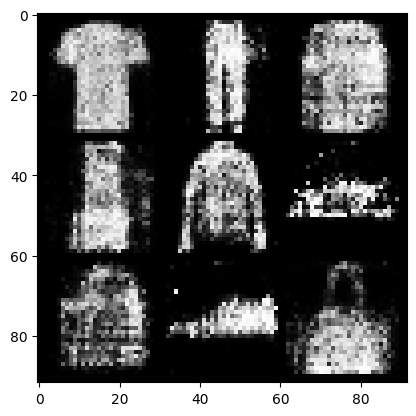

Starting epoch 28...
g_loss: 1.2947826385498047, d_loss: 1.0116496086120605


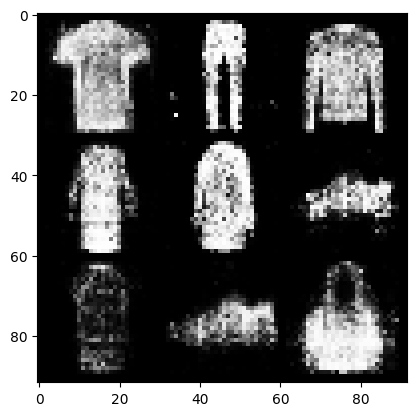

Starting epoch 29...
g_loss: 1.0083329677581787, d_loss: 1.3472275733947754


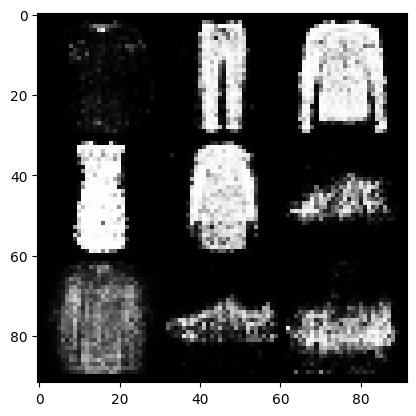

Starting epoch 30...
g_loss: 1.277076005935669, d_loss: 1.4603924751281738


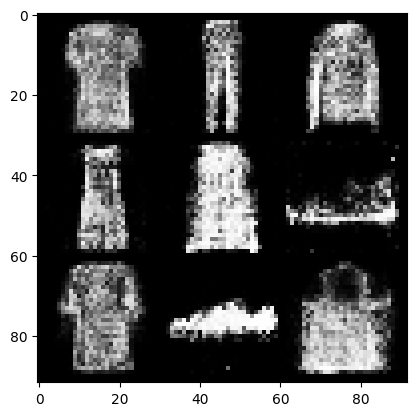

In [ ]:
for epoch in range(epochs):

    print('Starting epoch {}...'.format(epoch+1))

    for i, (images, labels) in enumerate(data_loader):

        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        generator.train()

        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()

    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    z = Variable(torch.randn(class_num-1, z_size)).to(device)

    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)

    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

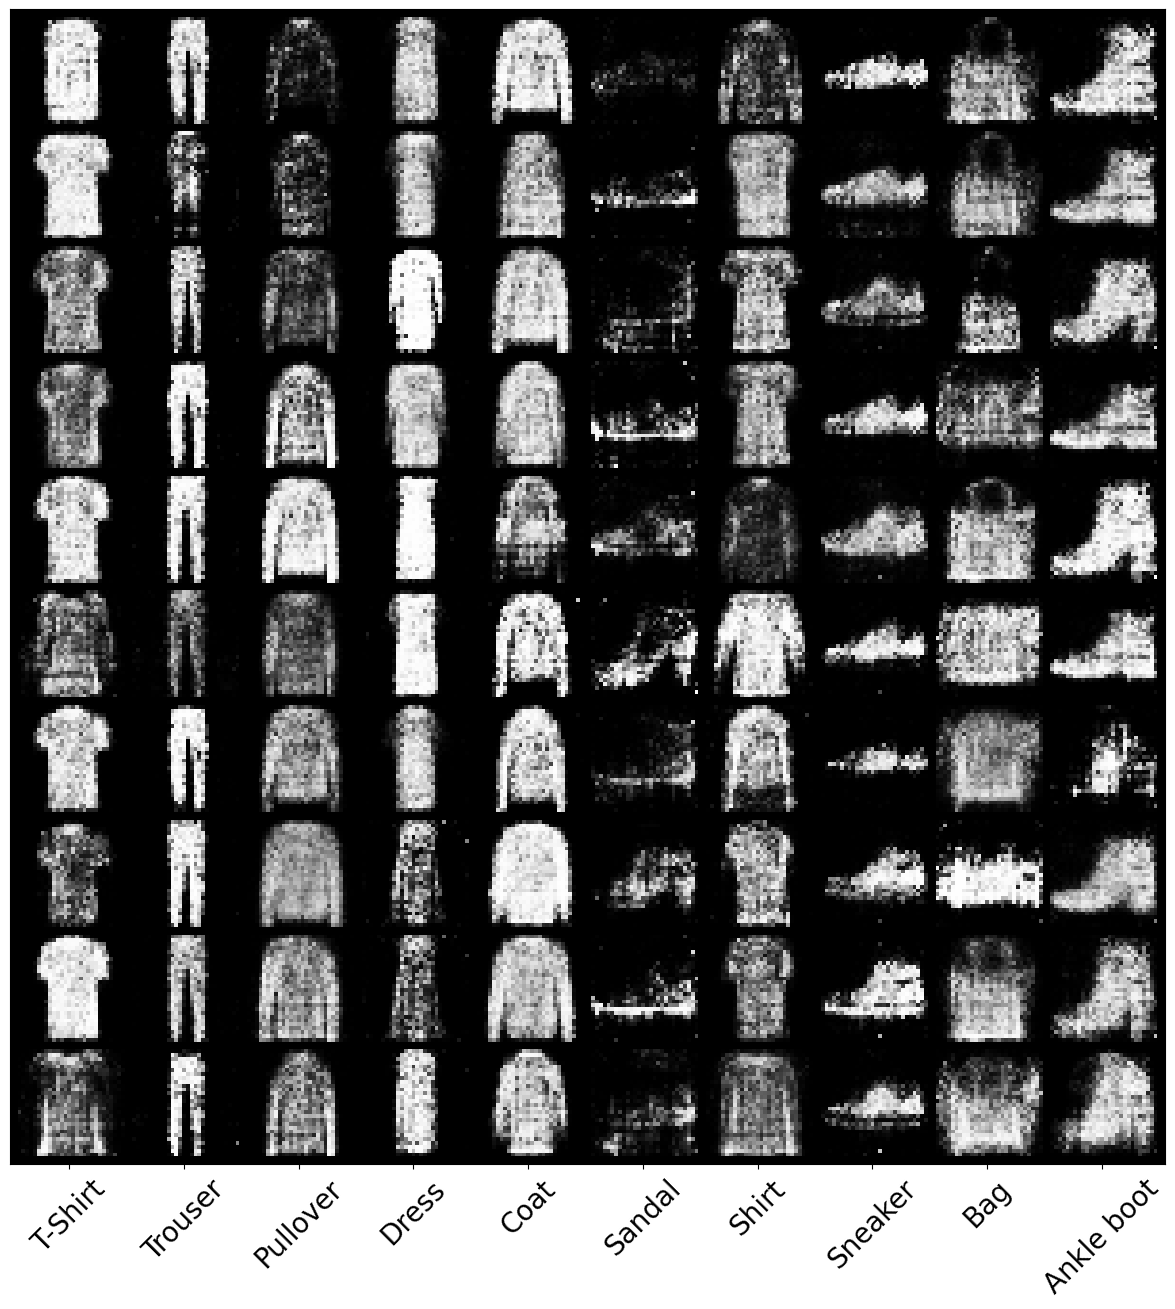

In [ ]:
# Generated Images Category wise
z = Variable(torch.randn(z_size, z_size)).to(device)

labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

sample_images = generator(z, labels).unsqueeze(1).data.cpu()

grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)